# Project 1: Contact Lens Manufacturing Failure Driver Analysis

## 1. Introduction / Overview

This project focuses on analyzing simulated data from a contact lens manufacturing process to develop a predictive model. The primary aim is to identify the key process variables significantly impacting batch yield.

In [33]:
# ## 2. Setup

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split


# Ignore specific warnings if desired
warnings.filterwarnings('ignore', category=FutureWarning)

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#print("Libraries imported and Google Drive mounted.")

## 3. Data Simulation & Preparation

This section simulates integrated batch-level data designed to reflect the scenario where different process variables, especially storage duration, influence batch success. A binary 'Failure_Flag' (1 for Fail, 0 for Pass) is simulated as the target variable, strongly influenced by storage time > 180 days.

In [34]:
# Simulation for Project 1

print("--- Simulating Integrated Batch Data for Failure Analysis ---")

N_BATCHES_P1 = 3000 # Number of batches to simulate

# Basic Batch Info
batch_ids_p1 = [f'P1_B{10000 + i:05d}' for i in range(N_BATCHES_P1)]
mould_lines_p1 = np.random.choice([1, 2, 3], N_BATCHES_P1, p=[0.3, 0.3, 0.4])
powers_p1 = np.round(np.random.choice(np.arange(-10.00, 6.00 + 0.25, 0.25), N_BATCHES_P1), 2)

# Simulate Storage Duration (Key Feature)
storage_days_long_p1 = np.random.randint(181, 450, int(N_BATCHES_P1 * 0.25)) # 25% long
storage_days_short_p1 = np.random.randint(10, 181, int(N_BATCHES_P1 * 0.75)) # 75% short
storage_duration_days_p1 = np.concatenate([storage_days_long_p1, storage_days_short_p1])
np.random.shuffle(storage_duration_days_p1)

# Simulate Upstream QC Results (Simple)
mould_qc_fail_prob_p1 = 0.05 + (mould_lines_p1 == 3) * 0.05 # Line 3 slightly higher fail rate
mould_qc_results_p1 = np.array(['Fail' if np.random.rand() < p else 'Pass' for p in mould_qc_fail_prob_p1])
filling_qc_results_p1 = np.array(['Fail' if np.random.rand() < 0.06 else 'Pass' for _ in range(N_BATCHES_P1)]) # Simple 6% fail rate

# --- Simulate Target: Failure_Flag (Binary) ---
# Base probability of failure
base_fail_prob_p1 = 0.05 # Low base failure rate
# Significant penalty for long storage
storage_penalty_p1 = (storage_duration_days_p1 > 180) * 0.40 # High chance of failure if stored long
# Smaller penalties for QC fails
mould_qc_penalty_p1 = (mould_qc_results_p1 == 'Fail') * 0.10
filling_qc_penalty_p1 = (filling_qc_results_p1 == 'Fail') * 0.08
# Random noise
random_noise_p1 = np.random.normal(0, 0.02, N_BATCHES_P1)

# Combine probabilities and clip between 0 and 1
total_fail_prob_p1 = base_fail_prob_p1 + storage_penalty_p1 + mould_qc_penalty_p1 + filling_qc_penalty_p1 + random_noise_p1
total_fail_prob_p1 = np.clip(total_fail_prob_p1, 0.01, 0.95) # Ensure probability is valid

# Generate binary flag: 1 if random draw < fail probability, else 0
failure_flag = (np.random.rand(N_BATCHES_P1) < total_fail_prob_p1).astype(int)


# Assemble DataFrame
batch_data_p1 = pd.DataFrame({
    'Batch_ID': batch_ids_p1,
    'Power': powers_p1,
    'Mould_Line': mould_lines_p1,
    'Storage_Duration_Days': storage_duration_days_p1,
    'Mould_QC_Result': mould_qc_results_p1,
    'Filling_QC_Result': filling_qc_results_p1,
    'Failure_Flag': failure_flag # Our Target Variable
})

print(f"\nSimulated batch data for Project 1 created ('batch_data_p1'). Shape: {batch_data_p1.shape}")
print("Target Variable: 'Failure_Flag' (1=Fail, 0=Pass)")
print("Value Counts for Failure_Flag:")
print(batch_data_p1['Failure_Flag'].value_counts(normalize=True)) # See proportion of failures
print("\nData Head:")
print(batch_data_p1.head())

--- Simulating Integrated Batch Data for Failure Analysis ---

Simulated batch data for Project 1 created ('batch_data_p1'). Shape: (3000, 7)
Target Variable: 'Failure_Flag' (1=Fail, 0=Pass)
Value Counts for Failure_Flag:
Failure_Flag
0    0.836667
1    0.163333
Name: proportion, dtype: float64

Data Head:
    Batch_ID  Power  Mould_Line  Storage_Duration_Days Mould_QC_Result  \
0  P1_B10000  -4.75           1                     64            Pass   
1  P1_B10001  -3.50           2                    111            Pass   
2  P1_B10002 -10.00           3                    172            Pass   
3  P1_B10003   3.25           2                     75            Pass   
4  P1_B10004   0.25           1                    421            Pass   

  Filling_QC_Result  Failure_Flag  
0              Pass             0  
1              Pass             1  
2              Pass             0  
3              Pass             0  
4              Pass             1  



## 4. Exploratory Data Analysis (EDA)

This section explores the simulated batch data to understand the distribution of key variables (like storage duration) and visualize their relationship with the `Failure_Flag` target (where 1 means failure, 0 means pass).

First, examine the distribution of the critical `Storage_Duration_Days` feature. We expect to see the simulated split between shorter (<181 days) and longer durations.

--- EDA: Distribution of Storage Duration ---


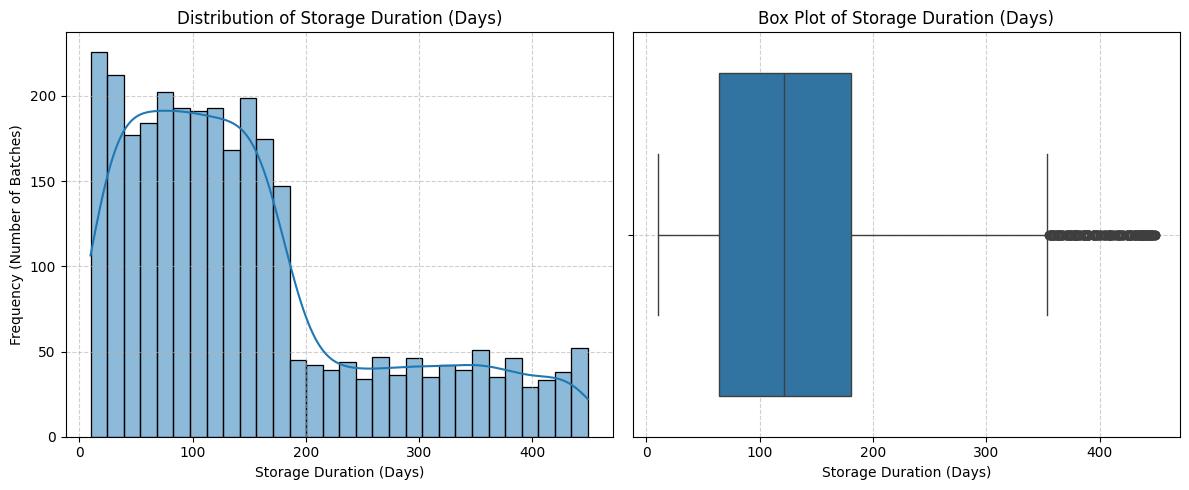


Descriptive Statistics for Storage_Duration_Days:
count    3000.000000
mean      148.206667
std       111.751215
min        10.000000
25%        64.000000
50%       121.500000
75%       180.250000
max       449.000000
Name: Storage_Duration_Days, dtype: float64


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is available

# Ensure batch_data_p1 exists
if 'batch_data_p1' not in locals() or not isinstance(batch_data_p1, pd.DataFrame):
    raise NameError("DataFrame 'batch_data_p1' not found. Please run the simulation cell first.")

print("--- EDA: Distribution of Storage Duration ---")

plt.figure(figsize=(12, 5))

# Histogram using Seaborn (provides density curve)
plt.subplot(1, 2, 1)
sns.histplot(data=batch_data_p1, x='Storage_Duration_Days', kde=True, bins=30)
plt.title('Distribution of Storage Duration (Days)')
plt.xlabel('Storage Duration (Days)')
plt.ylabel('Frequency (Number of Batches)')
plt.grid(True, linestyle='--', alpha=0.6)

# Box Plot using Seaborn
plt.subplot(1, 2, 2)
sns.boxplot(data=batch_data_p1, x='Storage_Duration_Days')
plt.title('Box Plot of Storage Duration (Days)')
plt.xlabel('Storage Duration (Days)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\nDescriptive Statistics for Storage_Duration_Days:")
print(batch_data_p1['Storage_Duration_Days'].describe())

**Interpretation: Storage Duration Distribution**

The histogram and box plot show the distribution of simulated pre-delensing storage times. As designed in the simulation, there's a higher frequency of batches with shorter storage durations (less than 180 days) and a smaller group with longer durations (extending up to ~450 days). The median storage duration falls within the shorter period. This confirms the simulated data includes the variable storage times needed for analysis.

Check the counts for the simulated upstream QC results ('Pass' vs 'Fail'). We expect most batches to pass.


--- EDA: Distributions of Categorical QC Features ---


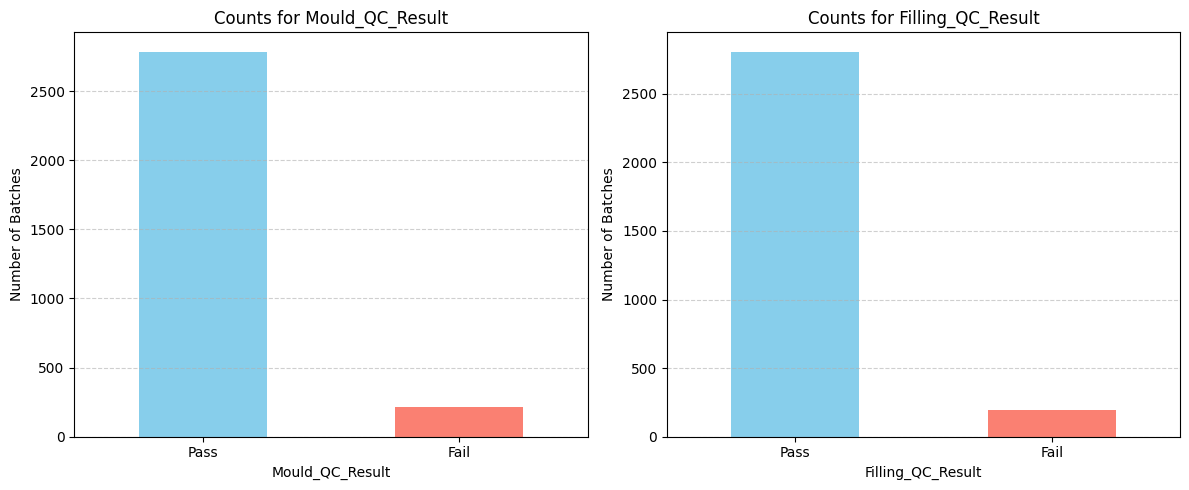

In [36]:
print("\n--- EDA: Distributions of Categorical QC Features ---")

qc_features = ['Mould_QC_Result', 'Filling_QC_Result']
existing_qc_features = [f for f in qc_features if f in batch_data_p1.columns]

if not existing_qc_features:
    print("QC features not found to plot.")
else:
    plt.figure(figsize=(6 * len(existing_qc_features), 5)) # Adjust width

    for i, col in enumerate(existing_qc_features):
        plt.subplot(1, len(existing_qc_features), i + 1)
        batch_data_p1[col].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title(f'Counts for {col}')
        plt.xlabel(col)
        plt.ylabel('Number of Batches')
        plt.xticks(rotation=0) # Keep labels horizontal
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

**Interpretation: Upstream QC Result Distribution**

These count plots show the frequency of 'Pass' vs. 'Fail' outcomes for the simulated upstream QC steps (Mould Dimension and Filling). As expected from the low base failure rates programmed into the simulation (e.g., 3-6%), the vast majority of batches are marked as 'Pass', with only a small fraction marked as 'Fail'. This represents a typical scenario where upstream failures are relatively rare but potentially impactful.

Key analysis: How does storage duration relate to the likelihood of failure? A box plot comparing the storage duration distributions for 'Pass' (0) vs 'Fail' (1) batches is effective here.


--- EDA: Storage Duration vs. Failure Flag ---


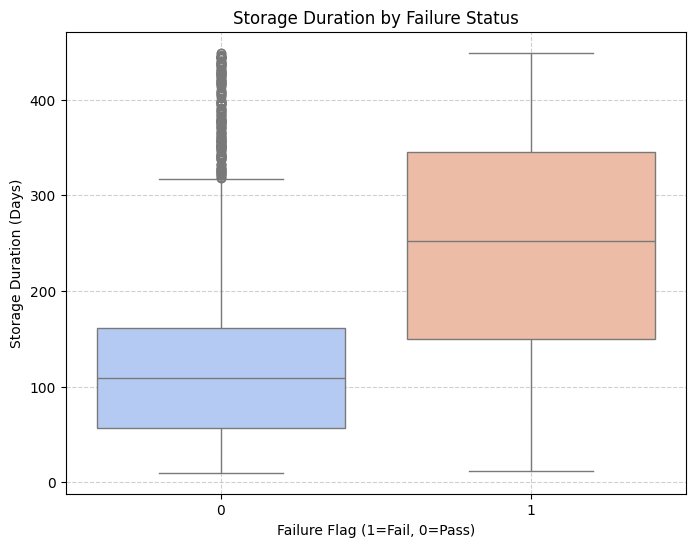


Average Storage Duration by Failure Status:
Failure_Flag
0    129.252988
1    245.295918
Name: Storage_Duration_Days, dtype: float64


In [37]:
print("\n--- EDA: Storage Duration vs. Failure Flag ---")
TARGET_P1 = 'Failure_Flag' # Define target variable name

if TARGET_P1 not in batch_data_p1.columns or 'Storage_Duration_Days' not in batch_data_p1.columns:
    print(f"Required columns '{TARGET_P1}' or 'Storage_Duration_Days' not found.")
else:
    plt.figure(figsize=(8, 6))
    # Box plot: Compare Storage Duration for Failed (1) vs Passed (0) batches
    sns.boxplot(data=batch_data_p1, x=TARGET_P1, y='Storage_Duration_Days', palette='coolwarm')
    plt.title('Storage Duration by Failure Status')
    plt.xlabel('Failure Flag (1=Fail, 0=Pass)')
    plt.ylabel('Storage Duration (Days)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Calculate average storage duration for failed vs passed batches
    print("\nAverage Storage Duration by Failure Status:")
    print(batch_data_p1.groupby(TARGET_P1)['Storage_Duration_Days'].mean())

**Interpretation: Storage Duration's Impact on Failure**

This box plot clearly visualizes the core hypothesis. The distribution of `Storage_Duration_Days` for batches that ultimately failed (`Failure_Flag = 1`) is significantly higher (higher median, shifted box) than for batches that passed (`Failure_Flag = 0`). This strongly suggests, within the simulated data, that longer storage duration is highly associated with an increased likelihood of failure, particularly confirming the impact of storage beyond ~180 days.

Check if upstream QC failures are associated with a higher failure rate downstream (as simulated). We can calculate the failure rate for each QC category.


--- EDA: QC Results vs. Failure Rate ---

Failure Rate (%) by Mould QC Result:
Mould_QC_Result
Fail    26.760563
Pass    15.536419
Name: Failure_Flag, dtype: float64


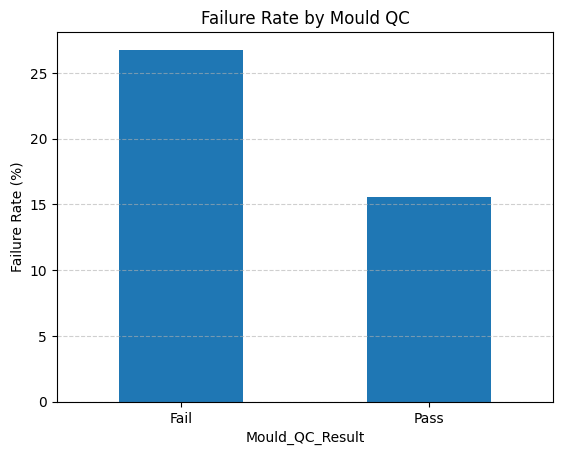


Failure Rate (%) by Filling QC Result:
Filling_QC_Result
Fail    23.560209
Pass    15.841937
Name: Failure_Flag, dtype: float64


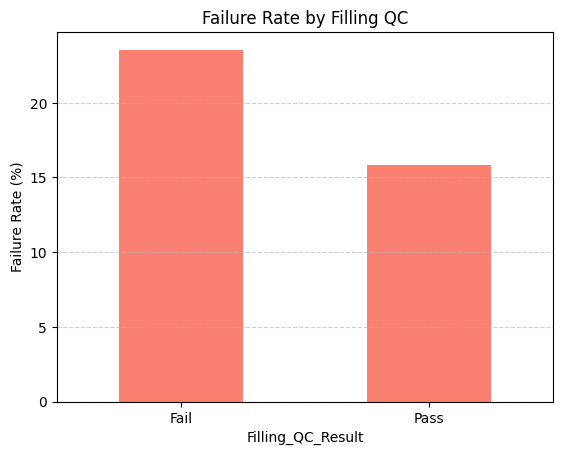

In [38]:
print("\n--- EDA: QC Results vs. Failure Rate ---")

# Calculate failure rate (%) grouped by QC results
if 'Mould_QC_Result' in batch_data_p1.columns:
    mould_qc_failure_rate = batch_data_p1.groupby('Mould_QC_Result')['Failure_Flag'].mean() * 100
    print("\nFailure Rate (%) by Mould QC Result:")
    print(mould_qc_failure_rate)

    mould_qc_failure_rate.plot(kind='bar', title='Failure Rate by Mould QC')
    plt.ylabel('Failure Rate (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


if 'Filling_QC_Result' in batch_data_p1.columns:
    filling_qc_failure_rate = batch_data_p1.groupby('Filling_QC_Result')['Failure_Flag'].mean() * 100
    print("\nFailure Rate (%) by Filling QC Result:")
    print(filling_qc_failure_rate)

    filling_qc_failure_rate.plot(kind='bar', title='Failure Rate by Filling QC', color='salmon')
    plt.ylabel('Failure Rate (%)')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

**Interpretation: Upstream QC Impact on Failure Rate**

The calculated failure rates grouped by upstream QC results confirm their influence. Batches simulated as failing either the `Mould_QC_Result` or `Filling_QC_Result` show a substantially higher downstream `Failure_Flag` rate compared to batches that passed upstream QC. This indicates that upstream quality issues, while less frequent, are strong predictors of subsequent failures, as expected.

## 5. Data Preprocessing & Feature Engineering

This section prepares the data for modeling. Key steps include selecting features and the target variable, one-hot encoding categorical features, and splitting the data into training and testing sets. Feature scaling is omitted as the planned models (Random Forest, Logistic Regression) are not sensitive to it.

In [39]:
# Preprocessing Step 1: Define Features (X) and Target (y)
import pandas as pd # Ensure pandas is imported

print("\n--- Defining Features (X) and Target (y) ---")

# Ensure batch_data_p1 exists
if 'batch_data_p1' not in locals() or not isinstance(batch_data_p1, pd.DataFrame):
    raise NameError("DataFrame 'batch_data_p1' not found. Ensure the simulation cell ran correctly.")

TARGET_P1 = 'Failure_Flag'

# Check if target exists
if TARGET_P1 not in batch_data_p1.columns:
    raise KeyError(f"Target column '{TARGET_P1}' not found in DataFrame.")

y = batch_data_p1[TARGET_P1]

# Define features (X) by dropping the target and any identifiers
features_to_drop_p1 = [TARGET_P1]
if 'Batch_ID' in batch_data_p1.columns:
    features_to_drop_p1.append('Batch_ID')

X = batch_data_p1.drop(columns=features_to_drop_p1)

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFeature columns selected for X (before encoding):")
print(X.columns.tolist())
print("\nTarget variable (Failure_Flag) counts:")
print(y.value_counts())


--- Defining Features (X) and Target (y) ---
Features (X) shape: (3000, 5)
Target (y) shape: (3000,)

Feature columns selected for X (before encoding):
['Power', 'Mould_Line', 'Storage_Duration_Days', 'Mould_QC_Result', 'Filling_QC_Result']

Target variable (Failure_Flag) counts:
Failure_Flag
0    2510
1     490
Name: count, dtype: int64


In [40]:
# Preprocessing Step 2: One-Hot Encode Categorical Features
import numpy as np

print("\n--- Applying One-Hot Encoding ---")

# Check if X exists
if 'X' not in locals() or not isinstance(X, pd.DataFrame):
     raise NameError("DataFrame 'X' not found. Run previous cell.")

# Identify categorical columns (object dtype + Mould_Line)
categorical_cols_p1 = X.select_dtypes(include='object').columns.tolist()
if 'Mould_Line' in X.select_dtypes(include=np.number).columns:
    if 'Mould_Line' not in categorical_cols_p1:
        categorical_cols_p1.append('Mould_Line')


print(f"  Categorical columns identified for encoding: {categorical_cols_p1}")

if not categorical_cols_p1:
    print("  No categorical columns needed encoding.")
    X_processed = X.copy() # Final X if no encoding needed
else:
    # Apply get_dummies
    X_processed = pd.get_dummies(X, columns=categorical_cols_p1, drop_first=True, dtype=int)
    print(f"\nShape of features after encoding: {X_processed.shape}")
    print("Columns after One-Hot Encoding:")
    print(X_processed.columns.tolist())

# Assign final processed features back to X
X = X_processed
print("\nDataFrame 'X' updated with encoded features.")


--- Applying One-Hot Encoding ---
  Categorical columns identified for encoding: ['Mould_QC_Result', 'Filling_QC_Result', 'Mould_Line']

Shape of features after encoding: (3000, 6)
Columns after One-Hot Encoding:
['Power', 'Storage_Duration_Days', 'Mould_QC_Result_Pass', 'Filling_QC_Result_Pass', 'Mould_Line_2', 'Mould_Line_3']

DataFrame 'X' updated with encoded features.


In [41]:
# Preprocessing Step 3: Train/Test Split
from sklearn.model_selection import train_test_split

print("\n--- Splitting Data into Training and Testing sets (80/20) ---")

# Check if X and y exist
if 'X' not in locals() or 'y' not in locals():
     raise NameError("Variables 'X' or 'y' not defined. Run previous cells.")
if X.shape[0] != y.shape[0]:
     raise ValueError(f"Shape mismatch: X has {X.shape[0]} rows, y has {y.shape[0]} rows.")

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,    # 20% for test set
    random_state=42,   # For reproducibility
    stratify=y         # Good practice for classification to keep target distribution similar in train/test
    )

print("Data split complete.")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape: {y_test.shape}")
print("\nTraining set target distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set target distribution:")
print(y_test.value_counts(normalize=True))

print("\nPreprocessing complete. Data ready for modeling.")
print("Variables ready: X_train, X_test, y_train, y_test")


--- Splitting Data into Training and Testing sets (80/20) ---
Data split complete.
  X_train shape: (2400, 6)
  X_test shape: (600, 6)
  y_train shape: (2400,)
  y_test shape: (600,)

Training set target distribution:
Failure_Flag
0    0.836667
1    0.163333
Name: proportion, dtype: float64

Test set target distribution:
Failure_Flag
0    0.836667
1    0.163333
Name: proportion, dtype: float64

Preprocessing complete. Data ready for modeling.
Variables ready: X_train, X_test, y_train, y_test


## 6. Modeling & Feature Importance Analysis

A Random Forest Classifier model is trained on the preprocessed batch data to predict the `Failure_Flag`. While model performance metrics are checked, the primary goal here is to extract and analyze the feature importances to identify the key drivers influencing batch failure in the simulation, particularly validating the impact of storage duration.


--- Training Random Forest Classifier for Feature Importance ---
Training model on 2400 samples...
Model training complete.

Evaluating model performance on test set (optional step)...
  Test Set Accuracy: 0.7967

Classification Report (Test Set):
              precision    recall  f1-score   support

    Pass (0)       0.93      0.82      0.87       502
    Fail (1)       0.42      0.68      0.52        98

    accuracy                           0.80       600
   macro avg       0.68      0.75      0.70       600
weighted avg       0.85      0.80      0.81       600


--- Analyzing Feature Importances ---

Top Feature Importances:
                  Feature  Importance
1   Storage_Duration_Days    0.713747
0                   Power    0.218911
2    Mould_QC_Result_Pass    0.021132
5            Mould_Line_3    0.017894
3  Filling_QC_Result_Pass    0.016402
4            Mould_Line_2    0.011914


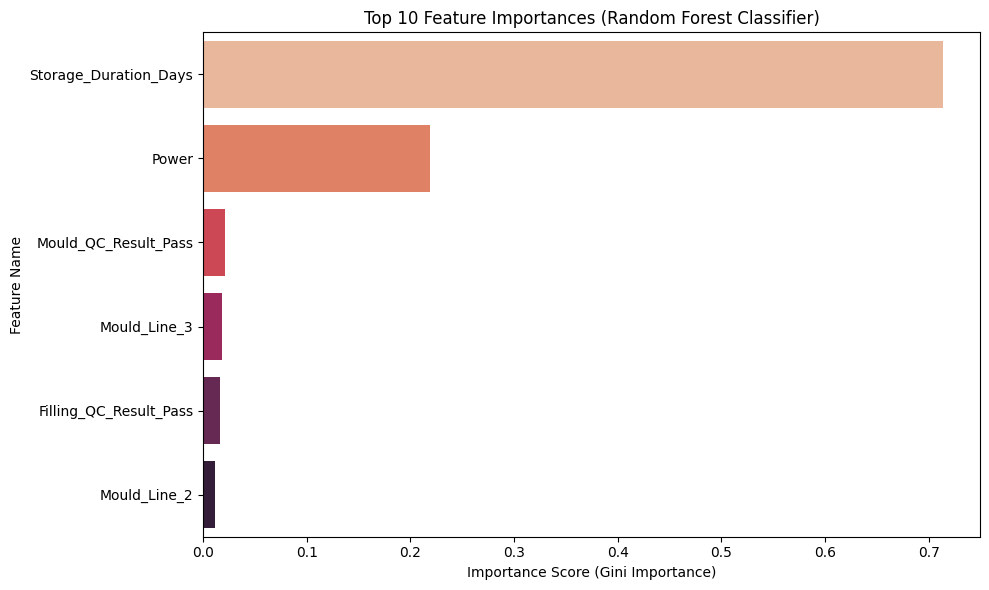

In [42]:
# Stage 6: Modeling & Feature Importance Analysis (Project 1)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Check if training/testing data exists (encoded X_train, X_test)
if 'X_train' not in locals() or 'X_test' not in locals() or \
   'y_train' not in locals() or 'y_test' not in locals():
    raise NameError("Required train/test data not found. Ensure preprocessing cells ran.")
if not isinstance(X_train, pd.DataFrame) or not isinstance(X_test, pd.DataFrame):
     raise TypeError("X_train/X_test should be DataFrames after encoding for feature names.")


print("\n--- Training Random Forest Classifier for Feature Importance ---")

# 1. Initialize the Model
# Using default parameters is sufficient for importance analysis
rf_clf = RandomForestClassifier(n_estimators=100, # Number of trees
                                random_state=42,
                                n_jobs=-1,        # Use all cores
                                class_weight='balanced', # Helpful if classes are imbalanced
                                max_depth=15,       # Limit depth slightly
                                min_samples_leaf=5)

# 2. Train the Model
print(f"Training model on {X_train.shape[0]} samples...")
rf_clf.fit(X_train, y_train)
print("Model training complete.")

# 3. Evaluate Model Performance
print("\nEvaluating model performance on test set (optional step)...")
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"  Test Set Accuracy: {accuracy:.4f}")
# Display classification report for more details (precision, recall, f1-score)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['Pass (0)', 'Fail (1)']))


# 4. Extract and Analyze Feature Importances (Primary Goal)
print("\n--- Analyzing Feature Importances ---")
importances = rf_clf.feature_importances_
feature_names = X_train.columns # Get feature names from training data columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Sort by importance

print("\nTop Feature Importances:")
print(importance_df.head(10)) # Print top 10 features

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='rocket_r') # Plot top 10
plt.title('Top 10 Feature Importances (Random Forest Classifier)')
plt.xlabel('Importance Score (Gini Importance)')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

## 7. Conclusion & Business Impact

The primary conclusion from this analysis is that managing the **storage duration** of filled moulds prior to delensing represents a critical opportunity for improving yield and reducing waste in this specific manufacturing context. The findings provide strong, data-driven justification for implementing or reinforcing operational strategies such as:

* **First-In, First-Out (FIFO):** Prioritizing the use of older inventory batches to minimize the time any batch spends in storage, particularly avoiding durations beyond the ~6-month threshold identified.
* **Inventory Optimization:** Using insights like this could inform better coordination between production planning and warehouse management.

By addressing the key factor identified through modeling, the business could potentially achieve significant **cost savings** through reduced material wastage and **increase effective daily output** due to higher batch success rates. This project also underscores the value unlocked by integrating data from different process stages to gain a holistic understanding.

## 8. Technologies Used

* Python
* Pandas (for Data Manipulation, Simulation)
* NumPy (for Numerical Operations, Simulation)
* Scikit-learn (for Regression Modeling, Feature Importance)
* Matplotlib & Seaborn (for Data Visualization, EDA)
* Google Colab (as the development environment)
* Git / GitHub (for version control and project hosting)

## 9. Limitations

* **Simulated Data:** The most significant limitation is that this analysis relies entirely on simulated data. Findings require validation using actual historical production data.
* **Scope of Simulation:** The simulation captured key assumed variables but inevitably simplifies the real-world manufacturing environment.
* **Model Focus:** The modeling effort centered on identifying the primary drivers (feature importance) rather than exhaustive hyperparameter tuning.

## 10. Future Work

* **Validation with Real Data:** Apply this analytical pipeline to actual historical production data.
* **Quantify Financial Impact:** If validated, estimate potential cost savings and yield improvements from optimized storage strategies.
* **Explore Secondary Factors:** Conduct deeper analysis into secondary factors identified by the model using real data.
* **Refine Simulation:** Enhance simulation with more granularity if real data remains inaccessible.